In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
import pygsp as pg
import pickle
import tensorflow as tf
from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils, utils2, plot
from tqdm import tqdm

2024-07-10 15:28:05.312357: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 15:28:12.877364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
cbc_low      = np.load('GWskymap/data/cbc_15snr_100prob.npy')
cbc_high     = np.load('GWskymap/data/cbc_30snr_100prob.npy')

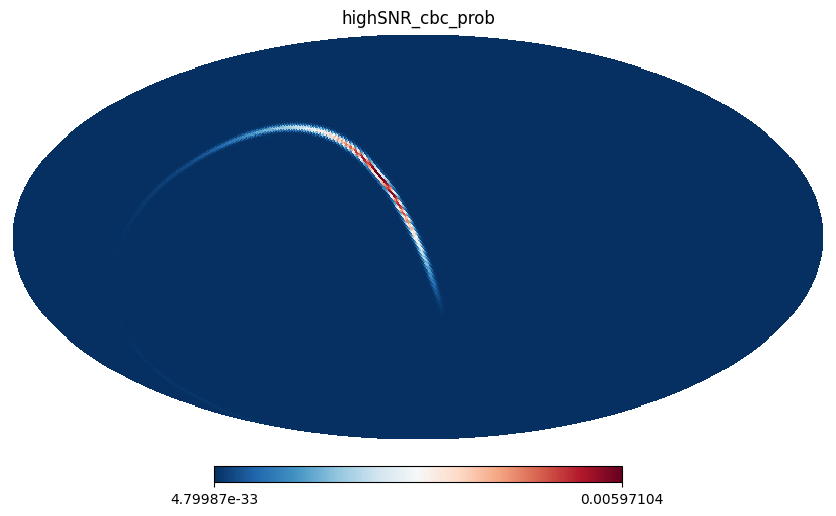

In [5]:
cm = plt.cm.RdBu_r
ipx = 0
hp.mollview(cbc_high[ipx], title='highSNR_cbc_prob', nest=True, cmap=cm)

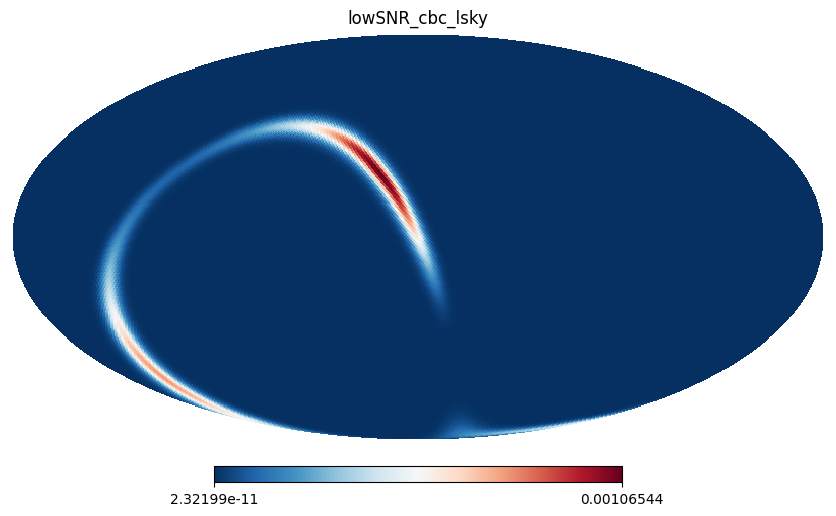

In [6]:
cm = plt.cm.RdBu_r
hp.mollview(cbc_low[ipx], title='lowSNR_cbc_lsky', nest=True, cmap=cm)

In [7]:
assert(len(cbc_low) == len(cbc_high))
nclass = len(cbc_high)

In [8]:
training_data = []
for m in cbc_high:
    m = hp.reorder(m, n2r=True)
    m = hp.smoothing(m, fwhm=.05)
    m = hp.reorder(m, r2n=True)
    training_data.append(100*m.astype(np.float32)[:,None])
training_data = np.array(training_data)

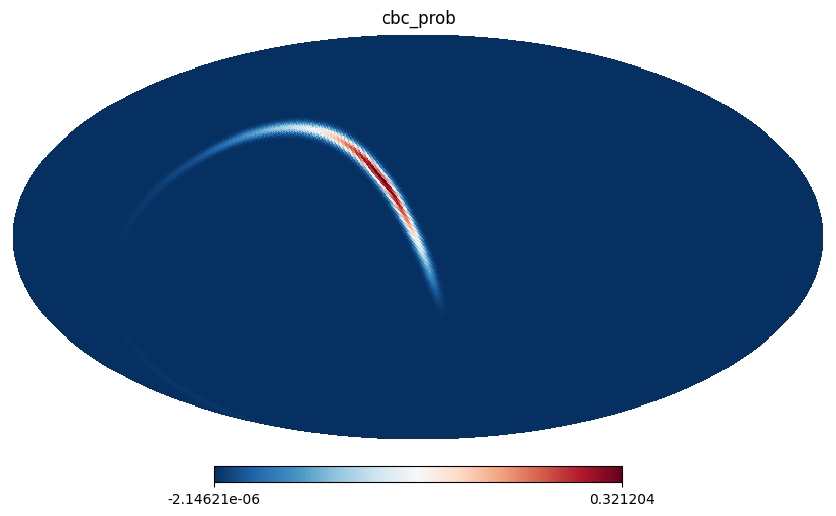

In [9]:
cmin = np.min(training_data)
cmax = np.max(training_data)
cm = plt.cm.RdBu_r
hp.mollview(training_data[ipx,:,0], title='cbc_prob', nest=True, cmap=cm)
# plt.save('plot')

# We define a UNet model combining HealpyPseudoCov

In [10]:
class UNetLayerDown(tf.keras.Model):
    def __init__(self, nside, indices, Fout, K=5, **kwargs):
        """
        Inits a layer that reduces the nside of the input, can be used in a UNet
        """
    
        # this line is necessary for all Model subclasses
        super(UNetLayerDown, self).__init__(**kwargs)

        # attributes
        self.nside = nside
        self.indices = indices
        
        # Add Conv1D layer
        self.conv1d_1 = tf.keras.layers.Conv1D(filters=Fout, kernel_size=3, padding='same', activation='elu')

        # init the network
        layers = [hp_layer.HealpyPseudoConv(p=1, Fout=Fout, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=Fout, use_bias=True, use_bn=False, activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                 ]
        self.gcnn = HealpyGCNN(nside=nside, 
                               indices=indices,
                               layers=layers
                              )
        
        self.conv1d_2 = tf.keras.layers.Conv1D(filters=Fout, kernel_size=3, padding='same', activation='elu')


    def call(self, input_tensor, training=False, *args, **kwargs):
        """
        Calls the block
        """
        x = self.conv1d_1(input_tensor, training=training)

        # output = self.gcnn(input_tensor, training=training, *args, **kwargs)
        x = self.gcnn(x, training=training, *args, **kwargs)
        
        # Apply another Conv1D layer
        x = self.conv1d_2(x, training=training)
        
        
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'nside': self.nside,
            'indices': self.indices.tolist(),
            'Fout': self.gcnn.layers[0].Fout,
            'K': self.gcnn.layers[1].K,
        })
        return config

    @classmethod
    def from_config(cls, config):
        config['indices'] = np.array(config['indices'])
        return cls(**config)

class UNetLayerUp(tf.keras.Model):
    def __init__(self, nside, indices, Fout, K=5, **kwargs):
        """
        Inits a layer that increases the nside of the input, can be used in a UNet
        """
    
        # this line is necessary for all Model subclasses
        super(UNetLayerUp, self).__init__(**kwargs)

        # attributes
        self.nside = nside
        self.indices = indices
        
        # Add Conv1D layer
        self.conv1d_1 = tf.keras.layers.Conv1D(filters=Fout, kernel_size=3, padding='same', activation='elu')

        # init the network
        layers = [hp_layer.HealpyChebyshev(K=K, Fout=Fout, use_bias=True, use_bn=False, activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=Fout, activation="elu"),
                 ]
        self.gcnn = HealpyGCNN(nside=nside, 
                               indices=indices,
                               layers=layers
                              )
        
        # Add another Conv1D layer
        self.conv1d_2 = tf.keras.layers.Conv1D(filters=Fout, kernel_size=3, padding='same', activation='elu')

    def call(self, input_tensor, training=False, *args, **kwargs):
        """
        Calls the block
        """
        # Apply Conv1D layer
        x = self.conv1d_1(input_tensor, training=training)

        # output = self.gcnn(input_tensor, training=training, *args, **kwargs)
        # Pass through HealpyGCNN
        x = self.gcnn(x, training=training, *args, **kwargs)
        
        # Apply another Conv1D layer
        x = self.conv1d_2(x, training=training)
        
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'nside': self.nside,
            'indices': self.indices.tolist(),
            'Fout': self.gcnn.layers[0].Fout,
            'K': self.gcnn.layers[0].K,
        })
        return config

    @classmethod
    def from_config(cls, config):
        config['indices'] = np.array(config['indices'])
        return cls(**config)

class HealpyUNet(tf.keras.Model):
    def __init__(self, nside, indices, n_blocks=3, channel_fac=2, output_channels=1, **kwargs):
        """
        Inits the Unet with a given number of blocks 
        """

        # this line is necessary for all Model subclasses
        super(HealpyUNet, self).__init__(**kwargs)

        # attributes
        self.nside = nside
        self.indices = indices
        self.n_blocks = n_blocks
        self.channel_fac = channel_fac
        self.output_channels = output_channels
        self.up_layers = []
        self.down_layers = []

        # the down blocks
        Fout = 4
        self.block_indices = []
        self.block_nsides = []
        for i in range(n_blocks):
            down_layer = UNetLayerDown(nside=nside, indices=indices, Fout=Fout)
            indices = down_layer.gcnn._transform_indices(nside_in=nside,
                                                         nside_out=nside//2,
                                                         indices=indices)

            # append
            self.block_indices.append(indices)
            self.block_nsides.append(nside)
            self.down_layers.append(down_layer)

            # update
            nside = nside // 2
            Fout = channel_fac*Fout

        # the up layers
        for i in reversed(range(n_blocks)):
            nside = self.block_nsides[i]
            indices = self.block_indices[i]
            Fout = Fout//channel_fac
            up_layer = UNetLayerUp(nside=nside, indices=indices, Fout=Fout)
            
            # append
            self.up_layers.append(up_layer)

        # the final projection
        # self.final_layer = tf.keras.layers.Conv1D(filters=output_channels, kernel_size=1)
        self.final_layer = tf.keras.layers.Conv1D(filters=output_channels, kernel_size=1, activation='sigmoid')

        

    def call(self, input_tensor, training=False, *args, **kwargs):
        """
        Calls the UNet
        """

        down_output = []
        for down_layer in self.down_layers:
            input_tensor = down_layer(input_tensor, training=False, *args, **kwargs)
            down_output.append(input_tensor)

        # for the first layer nothing happens we just go up again
        input_tensor = down_output.pop(-1)
        first_layer = self.up_layers[0]
        input_tensor = first_layer(input_tensor, training=False, *args, **kwargs)

        # we concat and up cycle
        for up_layer, d_out in zip(self.up_layers[1:], reversed(down_output)):
            input_tensor = tf.concat([input_tensor, d_out], axis=-1)
            input_tensor = up_layer(input_tensor, training=False, *args, **kwargs)

        # the final layer
        input_tensor = self.final_layer(input_tensor, training=False, *args, **kwargs)
        
        return input_tensor
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'nside': self.nside,
            'indices': self.indices.tolist(),
            'n_blocks': self.n_blocks,
            'channel_fac': self.channel_fac,
            'output_channels': self.output_channels,
        })
        return config

    @classmethod
    def from_config(cls, config):
        config['indices'] = np.array(config['indices'])
        return cls(**config)

In [11]:
nside = 64
n_pix = hp.nside2npix(nside)
indices = np.arange(n_pix)
model = HealpyUNet(nside, indices)
model.build(input_shape=(None, len(indices), 1))
model.summary(110)

Detected a reduction factor of 2.0, the input with nside 64 will be transformed to 32 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Detected a reduction factor of 2.0, the input with nside 32 will be transformed to 16 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Detected a reduction factor of 2.0, the input with nside 16 will be transformed to 8 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Detected a reduction factor of 0.5, the input with nside 16 will be transformed to 32 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Detected a reduction factor of 0.5, the input with nside 32 will be transformed to 64 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Detected a reduction factor of 0.5, the input with nside 64 will be transformed to 128 during a forward pass. Checki

/home/wasim.javed/.conda/envs/DeepGNN/lib/python3.11/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'healpy_u_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "healpy_u_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ u_net_layer_down (UNetLayerDown)               │ ?                                   │         0 (unbuilt) │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ u_net_layer_down_1 (UNetLayerDown)             │ ?                                   │         0 (unbuilt) │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ u_net_layer_down_2 (UNetLayerDown)             │ ?                                   │         0 (unbuilt) │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ u_net_layer_up (UNetLayerUp)                   │ ?                                   │         0 (unbuilt) │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ u_net_layer_up_1 (UNetLayerUp)                 │ ?                                   │         0 (unbuilt) │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ u_net_layer_up_2 (UNetLayerUp)                 │ ?                                   │         0 (unbuilt) │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ conv1d_15 (Conv1D)                             │ ?                                   │         0 (unbuilt) │
└────────────────────────────────────────────────┴─────────────────────────────────────┴─────────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
# # Define a simple step decay function
def step_decay(epoch):
    initial_rate = 0.01
    drop = 0.25
    epochs_drop = 10
    new_rate = initial_rate * drop ** np.floor((1 + epoch) / epochs_drop)
    return new_rate

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='MAE', metrics =["MAE"])
# # Learning rate should be 0.0005 or 0.0001, 1e-2
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss="MAE",
              metrics=["MAE"],
)

# Adding learning rate scheduler to callbacks
lr_scheduler = LearningRateScheduler(step_decay)
callbacks_list = [lr_scheduler]

In [ ]:
noisy_data = cbc_prob_low.reshape(-1, 49152, 1)

In [ ]:
noisy_lsky = cbc_lsky_low.reshape(-1, 49152, 1)

In [ ]:
print("Fit model on training data")
history = model.fit(
    x= noisy_lsky,
    y= training_data,
    batch_size=32,
    epochs=50,
    # validation_data=(X_val, y_val),
    callbacks=callbacks_list
)   

In [ ]:
# Assuming `model` is an instance of HealpyUNet
# model.save('/home/wasim.javed/TestMLs/deepSky_test1', save_format='tf')
model.save_weights('/home/wasim.javed/TestMLs/deepWeights/model_weights', save_format='h5')

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"], label="Training Loss")
# plt.plot(history.history["val_loss"], label="Validation Loss")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()
# plt.savefig('deepSky_history3')

In [ ]:
with open('/home/wasim.javed/TestMLs/deepWeights/model_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# reconstructing skymaps of WNB signals

In [12]:
new_maps = np.load('GWskymap/data/100_testing_maps.npy')

In [ ]:
cm = 'viridis'
hp.mollview(new_maps[0], title='new_cbc', nest=True, cmap=cm)

In [ ]:
new_maps_reshaped = new_maps.reshape(-1, 49152, 1)

In [ ]:
cbc_reconst = model(new_maps_reshaped, True).numpy()

In [ ]:
hp.mollview(cbc_reconst[0,:,0], title='reconstructed_15SNR_prob', nest=True, cmap='viridis')